In [1]:
# %%
%load_ext autoreload
%autoreload 2

# %%
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from os.path import join
import pickle as pkl
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core.img_patch_stats_analysis_lib import compute_crossing_points, sweep_and_create_sample_store, process_img_mean_cov_statistics,\
     process_patch_mean_cov_statistics, plot_variance_trajectories, plot_mean_deviation_trajectories, \
     harmonic_mean, smooth_and_find_threshold_crossing
from core.trajectory_convergence_lib import analyze_and_plot_variance
from circuit_toolkit.plot_utils import saveallforms

# %%
# from core.edm_dataset import load_dataset
def load_dataset(dataset_name, normalize=True):
    import sys
    import torchvision
    import torchvision.transforms as transforms
    sys.path.append("/n/home12/binxuwang/Github/edm")
    from training.dataset import TensorDataset, ImageFolderDataset
    edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
    word_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset"
    if dataset_name == "FFHQ":
        edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
        dataset = ImageFolderDataset(edm_ffhq64_path)
        imgsize = 64
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "AFHQ":
        edm_afhq_path = join(edm_dataset_root, "afhqv2-64x64.zip")
        dataset = ImageFolderDataset(edm_afhq_path)
        imgsize = 64
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "CIFAR":
        edm_cifar_path = join(edm_dataset_root, "cifar10-32x32.zip")
        dataset = ImageFolderDataset(edm_cifar_path)
        imgsize = 32
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "MNIST":
        dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                            train=True, download=True, 
                            transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]))
        imgsize = 32
        Xtsr_raw = torch.stack([dataset[i][0] for i in range(len(dataset))])
        # mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
        # print(mnist_Xtsr.shape) # 60000 x 32 x 32
        # Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
    elif dataset_name == "afhq-32x32":
        Xtsr_raw = torch.load(join(word_dataset_root, "afhq-32x32.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32-fix_words":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32-fixed_text.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32-random_word_jitter":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32-random_word_jitter1-4.pt"))
        imgsize = 32
    print(f"{dataset_name} dataset: {Xtsr_raw.shape}")
    print(f"Raw value range" , (Xtsr_raw[0].max().item()), (Xtsr_raw[0].min().item()))
    if normalize:
        print("Normalizing dataset to [-1.0, 1.0]")
        Xtsr = (Xtsr_raw - 0.5) / 0.5
    else:
        Xtsr = Xtsr_raw
    return Xtsr, imgsize

#%%
import time
def test_dataset_loading():
    """
    Test function to verify all datasets are loadable.
    This function attempts to load each dataset and prints basic information about it.
    """
    datasets_to_test = [
        "FFHQ", 
        "AFHQ", 
        "CIFAR", 
        "MNIST", 
        "afhq-32x32", 
        "ffhq-32x32", 
        "ffhq-32x32-fix_words", 
        "ffhq-32x32-random_word_jitter"
    ]
    
    results = {}
    
    print("Testing dataset loading...")
    print("-" * 50)
    
    for dataset_name in datasets_to_test:
        print(f"Loading dataset: {dataset_name}")
        try:
            start_time = time.time()
            Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
            load_time = time.time() - start_time
            
            results[dataset_name] = {
                "status": "Success",
                "shape": Xtsr.shape,
                "imgsize": imgsize,
                "min_value": Xtsr.min().item(),
                "max_value": Xtsr.max().item(),
                "load_time": f"{load_time:.2f} seconds"
            }
            
            print(f"  ✓ Successfully loaded {dataset_name}")
            print(f"    Shape: {Xtsr.shape}")
            print(f"    Image size: {imgsize}x{imgsize}")
            print(f"    Value range: [{Xtsr.min().item():.2f}, {Xtsr.max().item():.2f}]")
            print(f"    Load time: {load_time:.2f} seconds")
            
        except Exception as e:
            results[dataset_name] = {
                "status": "Failed",
                "error": str(e)
            }
            print(f"  ✗ Failed to load {dataset_name}")
            print(f"    Error: {str(e)}")
        
        print("-" * 50)
    
    # Summary
    print("\nDataset Loading Summary:")
    print("-" * 50)
    success_count = sum(1 for result in results.values() if result["status"] == "Success")
    print(f"Successfully loaded: {success_count}/{len(datasets_to_test)} datasets")
    
    for dataset_name, result in results.items():
        status_symbol = "✓" if result["status"] == "Success" else "✗"
        print(f"{status_symbol} {dataset_name}: {result['status']}")
    
    return results

# Uncomment the line below to run the test
test_results = test_dataset_loading()

Testing dataset loading...
--------------------------------------------------
Loading dataset: FFHQ
FFHQ dataset: torch.Size([70000, 3, 64, 64])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]
  ✓ Successfully loaded FFHQ
    Shape: torch.Size([70000, 3, 64, 64])
    Image size: 64x64
    Value range: [-1.00, 1.00]
    Load time: 17.40 seconds
--------------------------------------------------
Loading dataset: AFHQ
AFHQ dataset: torch.Size([15803, 3, 64, 64])
Raw value range 0.9803921580314636 0.0
Normalizing dataset to [-1.0, 1.0]
  ✓ Successfully loaded AFHQ
    Shape: torch.Size([15803, 3, 64, 64])
    Image size: 64x64
    Value range: [-1.00, 1.00]
    Load time: 3.64 seconds
--------------------------------------------------
Loading dataset: CIFAR
CIFAR dataset: torch.Size([50000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]
  ✓ Successfully loaded CIFAR
    Shape: torch.Size([50000, 3, 32, 32])
    Image size: 32x32
    Value range: [-1.00, 1

### FFHQ32 UNET MLP

In [2]:

Xtsr, imgsize = load_dataset("ffhq-32x32", normalize=True)
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"

ffhq-32x32 dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


In [3]:
#%% Load in the Sample Stores FFHQ MLP 
Xtsr, imgsize = load_dataset("ffhq-32x32", normalize=True)
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
expname = "FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm"
savedir = join(exproot, expname)
figdir = join(savedir, "figures")
os.makedirs(figdir, exist_ok=True)
sampledir = join(savedir, "samples")
sample_store = sweep_and_create_sample_store(sampledir)
#%%
imgshape = (3, 32, 32)
patch_size, patch_stride = 32, 1
step_slice = sorted(sample_store.keys())
img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
     process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)

ffhq-32x32 dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/494 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 70000 images


  0%|          | 0/494 [00:00<?, ?it/s]

In [5]:
figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/CNN_export_figs"
os.makedirs(figdir, exist_ok=True)

### Measure covariance alignment on eigenframe

In [6]:
from tqdm import trange, tqdm
import torch

def compute_cov_alignment(cov_matrix: torch.Tensor,
                          eigen_vectors: torch.Tensor
                         ) -> torch.Tensor:
    """
    Compute per-eigenvector alignment of a covariance matrix,
    plus a single joint alignment score.

    - rotated_cov = V^T @ C @ V
    
    - per-axis alignment_i = rotated_cov[i,i] / trace(rotated_cov)
    - joint alignment = sum_i (alignment_i ** 2)

    The joint score lies in [1/d, 1]:
      - 1 means *all* variance sits on a single axis (perfect alignment),
      - 1/d means variance is *uniformly* spread across axes (no alignment).
    
    Args:
        cov_matrix: (..., d, d) symmetric PSD
        eigen_vectors: (..., d, d) orthonormal columns = eigenbasis V

    Returns:
        alignment:       (..., ) vector of fractions of power on diagonal / total power
    """
    # Rotate into eigenbasis
    vt_c = torch.matmul(eigen_vectors.transpose(-1, -2), cov_matrix)
    cov_rot = torch.matmul(vt_c, eigen_vectors)
    # Per-axis variance
    var_on_axis = torch.diagonal(cov_rot)  # (d,)
    # Calculate alignment score (sum of squared normalized diagonal elements)
    diag_power = (var_on_axis**2).sum()
    total_var = (cov_rot**2).sum()
    # Alignment score (scalar)
    alignment = diag_power / total_var
    return alignment

In [8]:
compute_cov_alignment(cov_x_sample_traj[-1].cuda(), img_eigvec.cuda())

tensor(0.9752, device='cuda:0')

In [9]:
eigen_alignment_score = []
for i in trange(len(cov_x_sample_traj)):
    alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
    eigen_alignment_score.append(alignment_score)
    
eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
eigen_alignment_score.shape


100%|██████████| 494/494 [00:04<00:00, 99.50it/s] 


torch.Size([494])

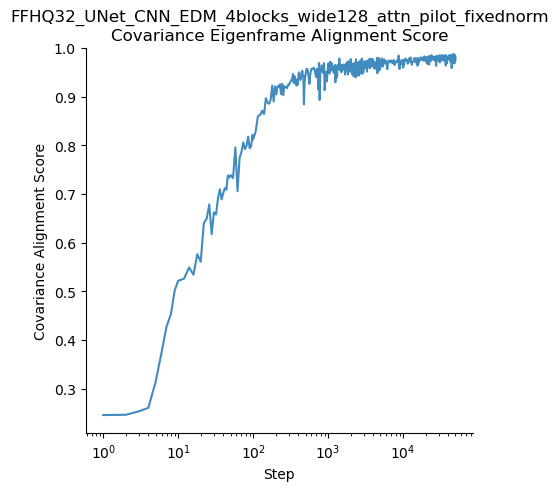

In [10]:
plt.figure(figsize=(5, 5))
plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
plt.xscale("log")
plt.ylim(None, 1)
plt.ylabel("Covariance Alignment Score")
plt.xlabel("Step")
plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
plt.show()
# plt.savefig(join(figdir, "eigenvector_alignment_score_ffhq_mlp.png"), dpi=300)

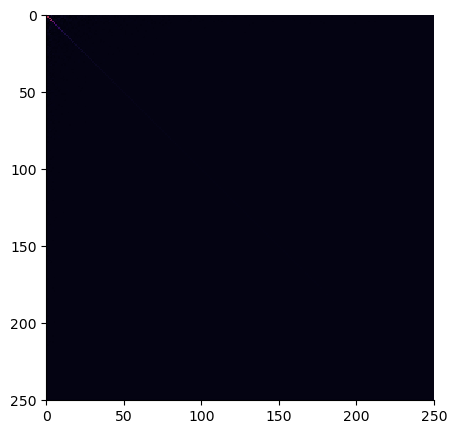

In [11]:
# plot the covariance matrix in the eigenbasis
plt.figure(figsize=(5, 5))
# cov_x_sample_traj[i].cuda(), img_eigvec.cuda()
cov_rot = img_eigvec.cuda().T @ cov_x_sample_traj[-1].cuda() @ img_eigvec.cuda()
plt.pcolor(cov_rot.cpu().numpy()[:250,:250], cmap="inferno", rasterized=True)
# reverse the y-axis
plt.gca().invert_yaxis()
# plt.colorbar(label="Variance")
# plt.title("Covariance Matrix in True Eigenbasis")
# plt.xlabel("Training Step")
# plt.ylabel("Eigenvector index")
plt.show()

In [12]:
cov_rot

tensor([[ 1.1113e+02, -1.6649e+00,  2.0132e-01,  ...,  1.4842e-03,
         -3.7263e-03,  2.7216e-04],
        [-1.6649e+00,  5.2147e+01, -7.2844e-01,  ...,  3.1738e-04,
         -3.4641e-04,  2.3332e-04],
        [ 2.0132e-01, -7.2845e-01,  4.5367e+01,  ...,  2.3636e-04,
          5.2798e-04,  2.0308e-03],
        ...,
        [ 1.4834e-03,  3.1795e-04,  2.3591e-04,  ...,  3.2070e-05,
         -1.3350e-06,  3.6567e-06],
        [-3.7263e-03, -3.4437e-04,  5.2835e-04,  ..., -1.3381e-06,
          2.7089e-05, -1.4371e-06],
        [ 2.7305e-04,  2.3360e-04,  2.0304e-03,  ...,  3.6570e-06,
         -1.4371e-06,  2.7995e-05]], device='cuda:0')

### Plot the variance heatmap

In [14]:
from core.trajectory_convergence_lib import smooth_and_find_threshold_crossing, compute_crossing_points
from core.img_patch_stats_analysis_lib import plot_variance_trajectories

In [15]:
emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")

In [16]:
# find the eigen index that the initial variance and final variance are similar
var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]

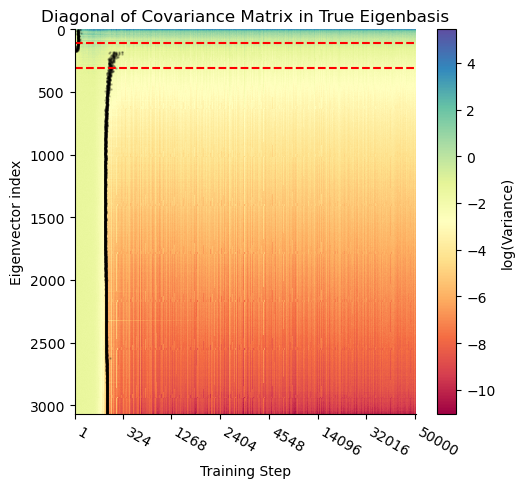

In [17]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
plt.show()

### Plot the classic variance trajectory

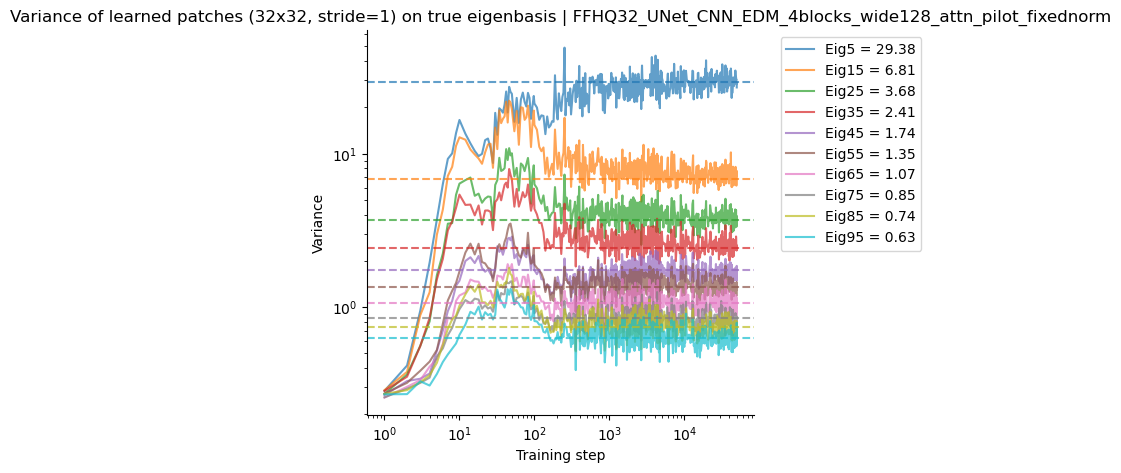

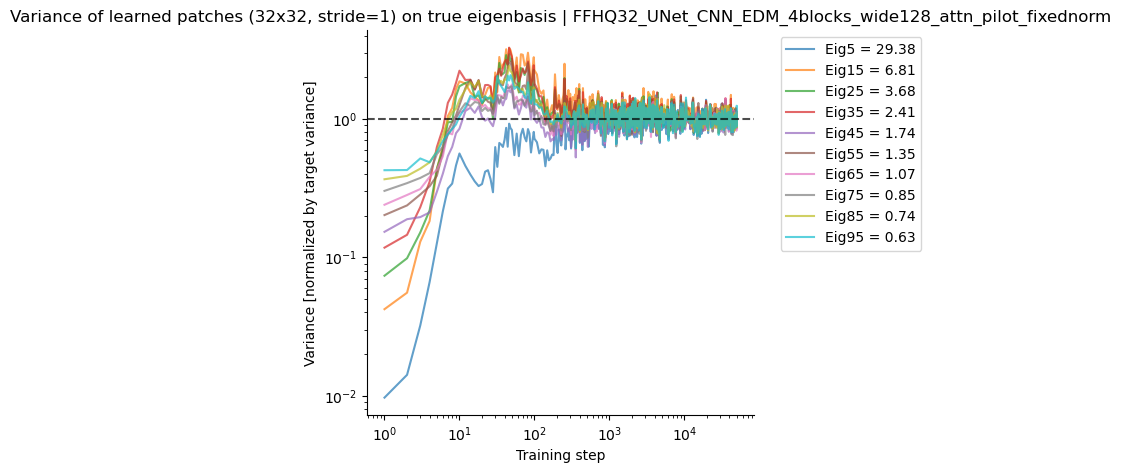

In [18]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))

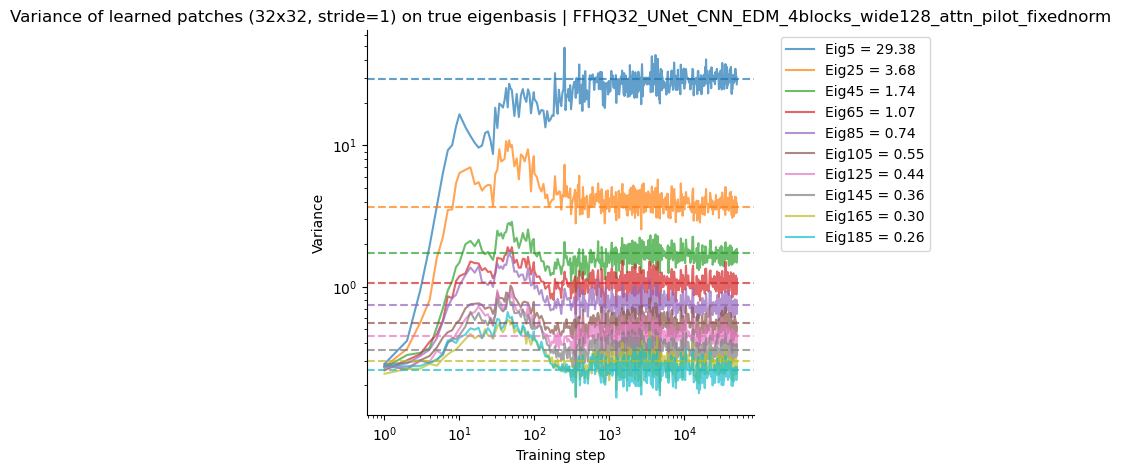

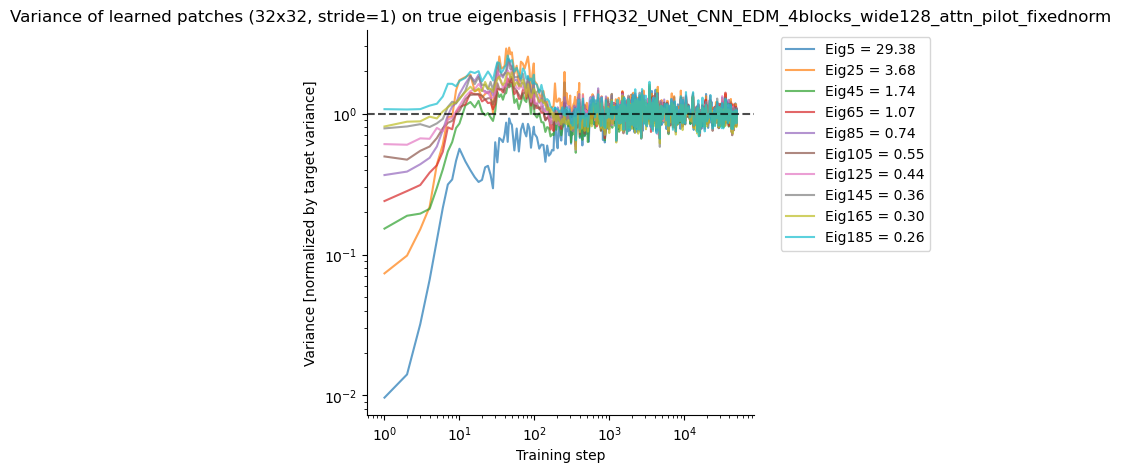

In [19]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))

### Plot the fit line

In [24]:

from sklearn.linear_model import LinearRegression
import pandas as pd
def fit_regression_log_scale(x, y, verbose=True):
    """Fit a linear regression model on log-transformed data."""
    # Log-transform the data
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    # mask out negative values
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    log_x = np.log(x)
    log_y = np.log(y)
    # simple linear regression
    # Use OLS from sklearn for linear regression
    model = LinearRegression().fit(log_x.reshape(-1, 1), log_y)
    slope = model.coef_[0]
    intercept = model.intercept_
    # Calculate r-squared
    r_squared = model.score(log_x.reshape(-1, 1), log_y)
    # Express the equation in the form of y = a * x^b
    a = np.exp(intercept)
    b = slope
    if verbose:
        print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}, R-squared: {r_squared:.2f} (log-log) [N={len(x)}]")
        print(f"Equation: $y = {a:.2f} x^{{{b:.2f}}}$")
    fit_dict = {
        "a": a,
        "b": b,
        "intercept": intercept,
        "slope": slope,
        "r_squared": r_squared,
        "N": len(x)
    }
    return fit_dict
# Example usage

In [26]:
emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")
init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

In [27]:
exclude_mask.sum()

182

In [28]:
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)

Direction: increase
Slope: -0.02, Intercept: 1.73, R-squared: 0.02 (log-log) [N=113]
Equation: $y = 5.67 x^{-0.02}$
Direction: decrease
Slope: 0.01, Intercept: 4.87, R-squared: 0.02 (log-log) [N=2777]
Equation: $y = 130.24 x^{0.01}$


Direction: increase
Slope: -0.02, Intercept: 1.73, R-squared: 0.02 (log-log) [N=113]
Equation: $y = 5.67 x^{-0.02}$
Direction: decrease
Slope: 0.01, Intercept: 4.87, R-squared: 0.02 (log-log) [N=2777]
Equation: $y = 130.24 x^{0.01}$


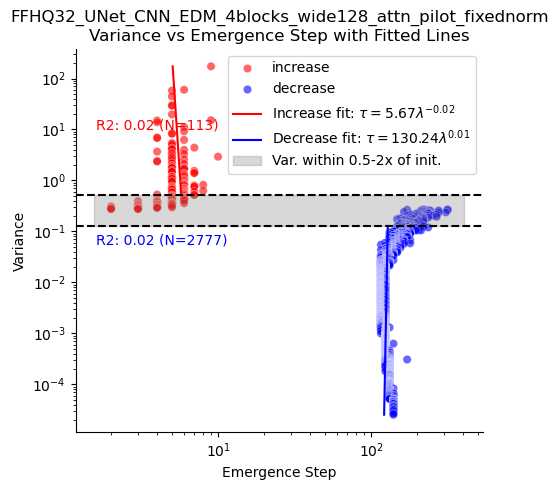

In [29]:
emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")

init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                          exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                          title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                          alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                          scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                          ax=None,
                          )
plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
plt.axhline(2 * mean_init_var, color="k", linestyle="--")
# fill the area between the two lines
XLIM = plt.gca().get_xlim()
plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                  color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
# annotate the R2 of the fit
plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
plt.legend()
saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
plt.show()

### Draw samples from the data

In [20]:
from circuit_toolkit.plot_utils import to_imgrid

1


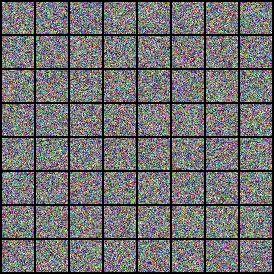

324


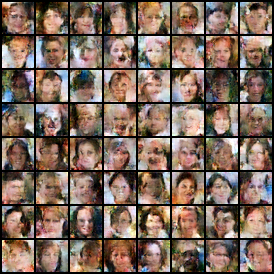

1268


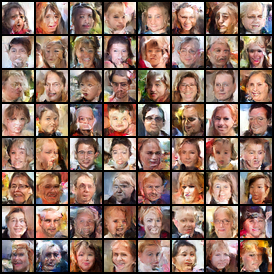

2404


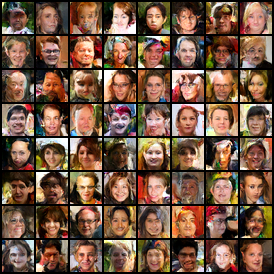

4548


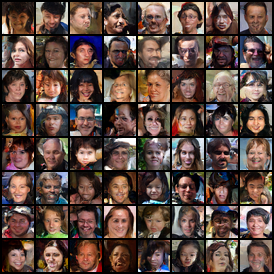

14096


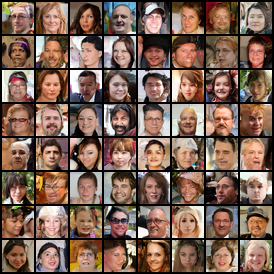

32016


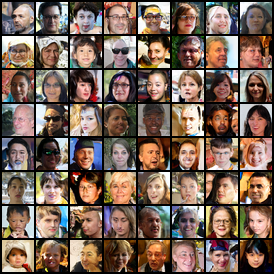

50000


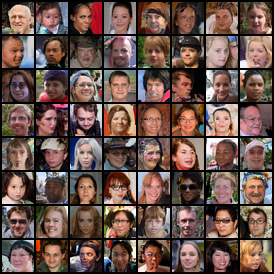

In [21]:
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:64]
    print(step_slice[i])
    display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))


1


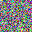

324


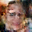

1268


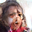

2404


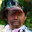

4548


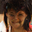

14096


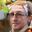

32016


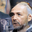

50000


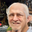

In [30]:
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
    print(step_slice[i])
    display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))


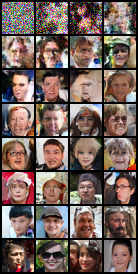

In [23]:
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
sample_col = []
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
    sample_col.append(sample_Xtsr)
sample_col = torch.cat(sample_col, dim=0)
display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

### Fourier basis

In [31]:
sample_store[step_slice[-1]].shape

torch.Size([1000, 3, 32, 32])

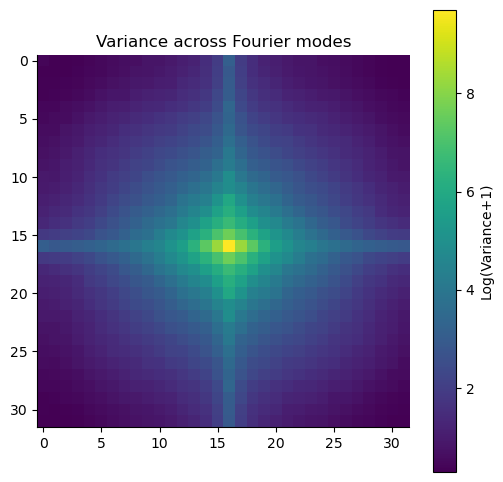

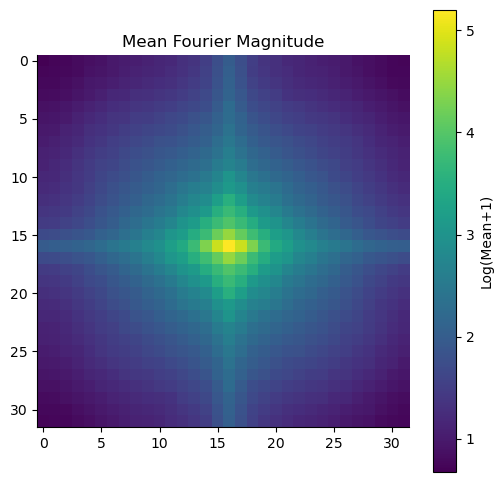

Original shape: torch.Size([1000, 3, 32, 32]), Fourier variance shape: torch.Size([32, 32, 3])


In [46]:
# Get the sample data
sample_data = sample_store[step_slice[100]]
sample_data = sample_data.reshape(-1, 3, 32, 32)  # Shape: [1000, 3, 32, 32]

# Apply FFT to convert to Fourier domain
# Move channels to last dimension for FFT
sample_data_perm = sample_data.permute(0, 2, 3, 1)  # [1000, 32, 32, 3]
fourier_data = torch.fft.fftn(sample_data_perm, dim=(1, 2))  # FFT on spatial dimensions

# Compute magnitude of complex values
fourier_magnitude = torch.abs(fourier_data)  # [1000, 32, 32, 3]

# Compute variance across samples for each Fourier mode
fourier_variance = torch.var(fourier_magnitude, dim=0)  # [32, 32, 3]

# Visualize the variance (log scale for better visibility)
plt.figure(figsize=(6, 6))
# Take mean across channels for visualization
fourier_variance_mean = fourier_variance.mean(dim=-1)
# Shift zero frequency to center for better visualization
fourier_variance_shifted = torch.fft.fftshift(fourier_variance_mean)
plt.imshow(torch.log1p(fourier_variance_shifted.cpu()), cmap='viridis')
plt.colorbar(label='Log(Variance+1)')
plt.title('Variance across Fourier modes')
plt.show()
# Visualize the mean Fourier magnitude
plt.figure(figsize=(6, 6))
# Take mean across channels for visualization
fourier_mean_vis = fourier_magnitude.mean(dim=0).mean(dim=-1)  # Average across samples and channels
# Shift zero frequency to center for better visualization
fourier_mean_shifted = torch.fft.fftshift(fourier_mean_vis)
plt.imshow(torch.log1p(fourier_mean_shifted.cpu()), cmap='viridis')
plt.colorbar(label='Log(Mean+1)')
plt.title('Mean Fourier Magnitude')
plt.show()

print(f"Original shape: {sample_data.shape}, Fourier variance shape: {fourier_variance.shape}")

In [47]:
# Get the sample data
fourier_variance_col = []
for i in range(len(step_slice)):
    sample_data = sample_store[step_slice[i]]
    sample_data = sample_data.reshape(-1, 3, 32, 32)  # Shape: [1000, 3, 32, 32]
    # Apply FFT to convert to Fourier domain
    # Move channels to last dimension for FFT
    sample_data_perm = sample_data.permute(0, 2, 3, 1)  # [1000, 32, 32, 3]
    fourier_data = torch.fft.fftn(sample_data_perm, dim=(1, 2))  # FFT on spatial dimensions
    # Compute magnitude of complex values
    fourier_magnitude = torch.abs(fourier_data)  # [1000, 32, 32, 3]
    # Compute variance across samples for each Fourier mode
    fourier_variance = torch.var(fourier_magnitude, dim=0)  # [32, 32, 3]
    fourier_variance_col.append(fourier_variance)
fourier_variance_col = torch.stack(fourier_variance_col, dim=0)
# # Visualize the variance (log scale for better visibility)
# plt.figure(figsize=(6, 6))
# # Take mean across channels for visualization
# fourier_variance_mean = fourier_variance.mean(dim=-1)

In [48]:
fourier_variance_col.shape

torch.Size([494, 32, 32, 3])

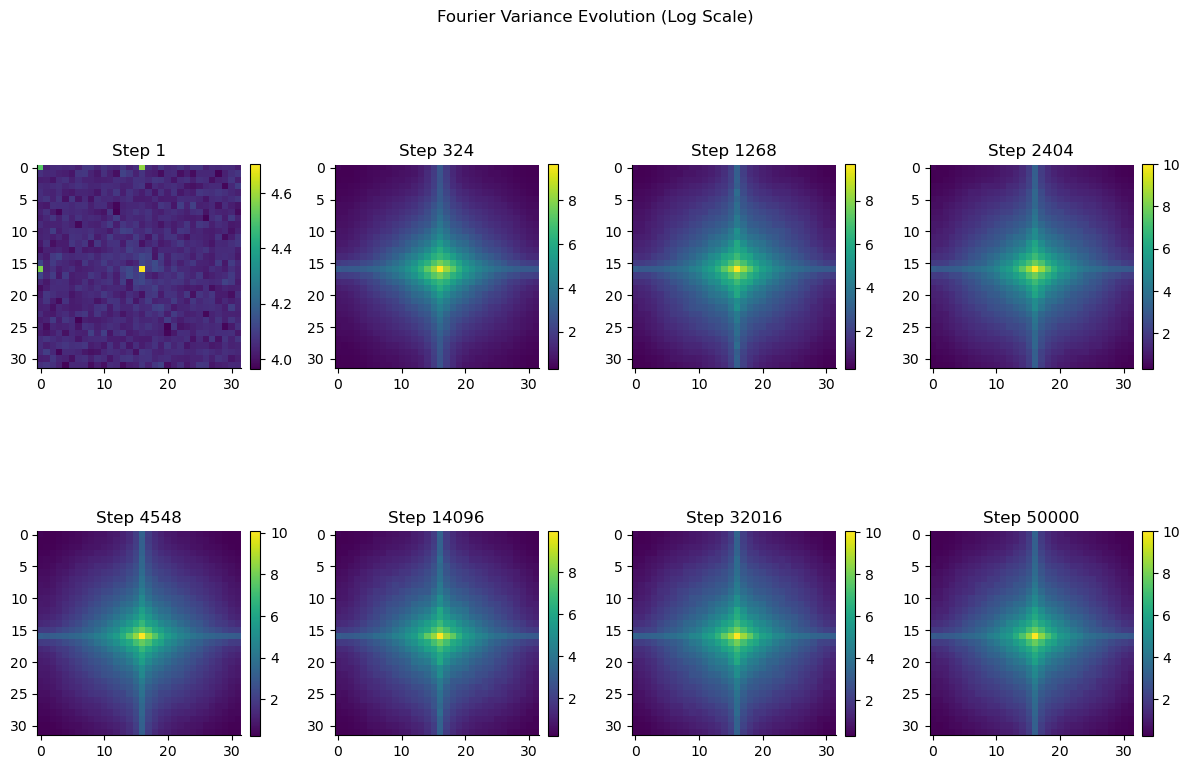

In [61]:
# Create a figure to visualize Fourier variance at different steps
plt.figure(figsize=(12, 8))
# Select 8 evenly spaced steps to visualize
num_steps_to_show = 8
step_indices = np.linspace(0, len(step_slice)-1, num_steps_to_show, dtype=int)
# Create subplots in a 2x4 grid
for i, step_idx in enumerate(step_indices):
    plt.subplot(2, 4, i+1)
    # Get the Fourier variance for this step
    fourier_var = fourier_variance_col[step_idx]
    # Take mean across channels for visualization
    fourier_var_mean = fourier_var.mean(dim=-1)
    # Shift zero frequency to center for better visualization
    fourier_var_shifted = torch.fft.fftshift(fourier_var_mean)
    # Plot with logarithmic scale for better visibility
    plt.imshow(torch.log1p(fourier_var_shifted.cpu()), cmap='viridis')
    # Add title with step information
    plt.title(f'Step {step_slice[step_idx]}')
    # Add colorbar to each subplot
    plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.suptitle('Fourier Variance Evolution (Log Scale)', y=1.05)
plt.show()


In [80]:
figoutdir = r"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/CNN_Fourier_basis_figs"

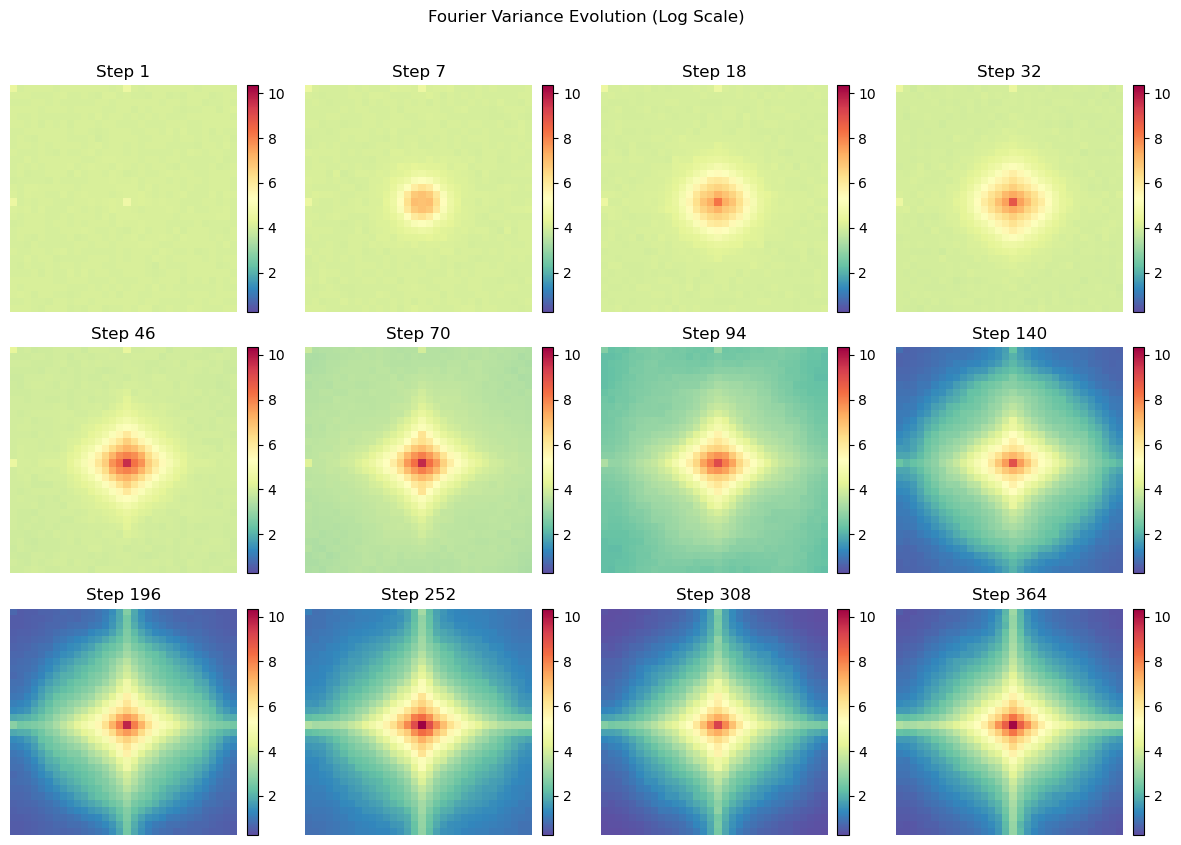

In [81]:

# Create a figure to visualize Fourier variance at different steps
# Select 8 evenly spaced steps to visualize
num_steps_to_show = 12
step_indices = np.linspace(0, 75, num_steps_to_show, dtype=int)
# Compute global min and max for consistent color scaling
all_log_values = []
for step_idx in step_indices:
    fourier_var = fourier_variance_col[step_idx]
    fourier_var_mean = fourier_var.mean(dim=-1)
    fourier_var_shifted = torch.fft.fftshift(fourier_var_mean)
    all_log_values.append(torch.log1p(fourier_var_shifted.cpu()))
vmin = min(tensor.min().item() for tensor in all_log_values)
vmax = max(tensor.max().item() for tensor in all_log_values)
plt.figure(figsize=(12, 8))
# Create subplots in a 3x4 grid
for i, step_idx in enumerate(step_indices):
    plt.subplot(3, 4, i+1)
    # Get the Fourier variance for this step
    fourier_var = fourier_variance_col[step_idx]
    # Take mean across channels for visualization
    fourier_var_mean = fourier_var.mean(dim=-1)
    # Shift zero frequency to center for better visualization
    fourier_var_shifted = torch.fft.fftshift(fourier_var_mean)
    # Plot with logarithmic scale for better visibility and consistent color limits
    plt.imshow(torch.log1p(fourier_var_shifted.cpu()), cmap='Spectral_r', vmin=vmin, vmax=vmax)
    plt.axis("off")
    # Add title with step information
    plt.title(f'Step {step_slice[step_idx]}')
    # Add colorbar to each subplot
    plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.suptitle('Fourier Variance Evolution (Log Scale)', y=1.05)
saveallforms(figoutdir, f"Fourier_variance_evolution_early_log_scale_{expname}", dpi=300)
plt.show()


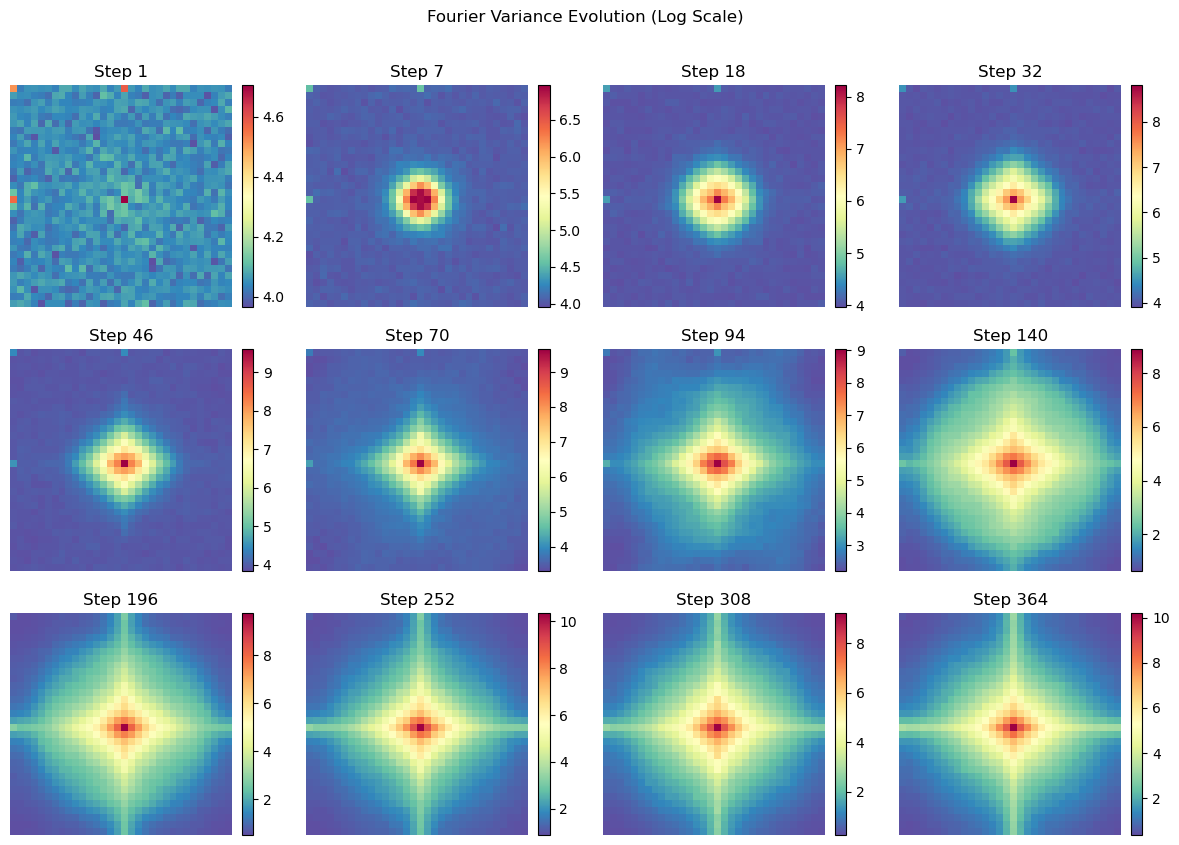

In [82]:

# Create a figure to visualize Fourier variance at different steps
# Select 8 evenly spaced steps to visualize
num_steps_to_show = 12
step_indices = np.linspace(0, 75, num_steps_to_show, dtype=int)
# Compute global min and max for consistent color scaling
plt.figure(figsize=(12, 8))
# Create subplots in a 3x4 grid
for i, step_idx in enumerate(step_indices):
    plt.subplot(3, 4, i+1)
    # Get the Fourier variance for this step
    fourier_var = fourier_variance_col[step_idx]
    # Take mean across channels for visualization
    fourier_var_mean = fourier_var.mean(dim=-1)
    # Shift zero frequency to center for better visualization
    fourier_var_shifted = torch.fft.fftshift(fourier_var_mean)
    # Plot with logarithmic scale for better visibility and consistent color limits
    plt.imshow(torch.log1p(fourier_var_shifted.cpu()), cmap='Spectral_r', )
    plt.axis("off")
    # Add title with step information
    plt.title(f'Step {step_slice[step_idx]}')
    # Add colorbar to each subplot
    plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.suptitle('Fourier Variance Evolution (Log Scale)', y=1.05)
saveallforms(figoutdir, f"Fourier_variance_evolution_early_log_scale_{expname}_unnorm", dpi=300)
plt.show()


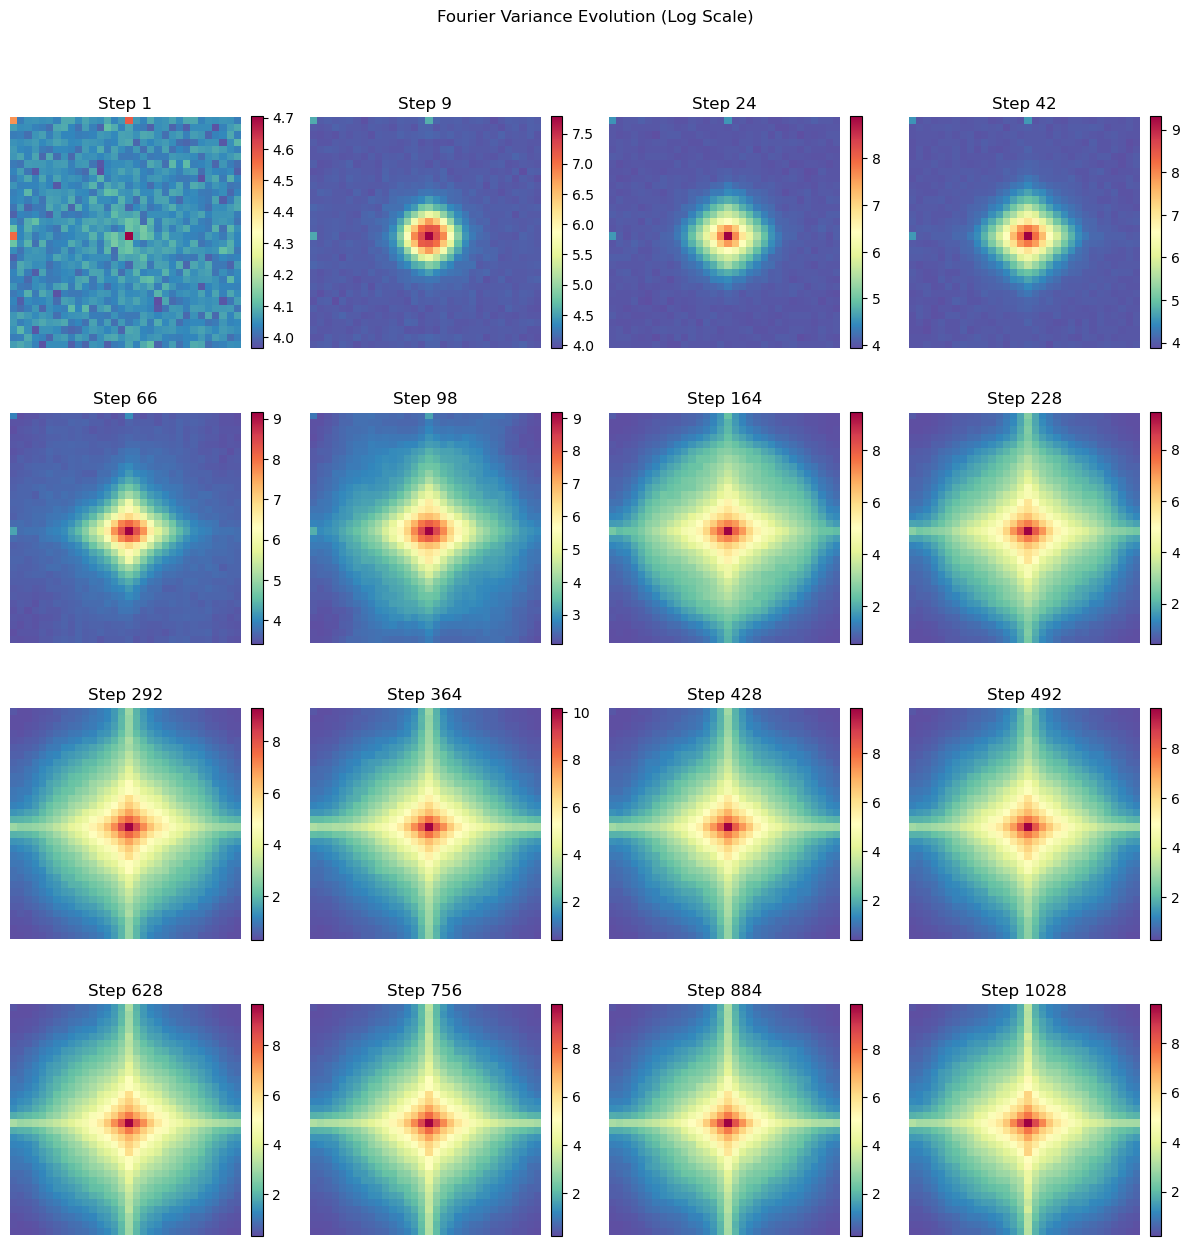

In [83]:

# Create a figure to visualize Fourier variance at different steps
# Select 8 evenly spaced steps to visualize
num_steps_to_show = 16
step_indices = np.linspace(0, 125, num_steps_to_show, dtype=int)
# Compute global min and max for consistent color scaling
plt.figure(figsize=(12, 12))
# Create subplots in a 3x4 grid
for i, step_idx in enumerate(step_indices):
    plt.subplot(4, 4, i+1)
    # Get the Fourier variance for this step
    fourier_var = fourier_variance_col[step_idx]
    # Take mean across channels for visualization
    fourier_var_mean = fourier_var.mean(dim=-1)
    # Shift zero frequency to center for better visualization
    fourier_var_shifted = torch.fft.fftshift(fourier_var_mean)
    # Plot with logarithmic scale for better visibility and consistent color limits
    plt.imshow(torch.log1p(fourier_var_shifted.cpu()), cmap='Spectral_r', )
    plt.axis("off")
    # Add title with step information
    plt.title(f'Step {step_slice[step_idx]}')
    # Add colorbar to each subplot
    plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.suptitle('Fourier Variance Evolution (Log Scale)', y=1.05)
saveallforms(figoutdir, f"Fourier_variance_evolution_mid_log_scale_{expname}_unnorm", dpi=300)
plt.show()


In [75]:
import torch

def variance_map_to_filter(variance_map: torch.Tensor, shifted=True) -> torch.Tensor:
    """
    Given a Fourier‐space variance map S(kx,ky) (real, shape H×W×C),
    compute a real‐valued spatial filter h(x,y) (shape H×W×C) satisfying
        |FFT2{h}|^2 ≈ S.

    Args:
        variance_map: torch.Tensor of shape (H, W, C)
                      (or (C, H, W)—we’ll handle both).

    Returns:
        h: torch.Tensor of shape (H, W, C), real spatial filter.
    """
    # -- reshape so channels-first: (C, H, W)
    if variance_map.ndim == 3:
        H, W, C = variance_map.shape
        S = variance_map.permute(2, 0, 1).contiguous()
    elif variance_map.ndim == 2:
        # single‐channel
        H, W = variance_map.shape
        S = variance_map.unsqueeze(0)
        C = 1
    else:
        raise ValueError("variance_map must be 2D or 3D (H×W×C)")

    # 1) magnitude = sqrt(variance)
    mag = torch.sqrt(S)

    # 2) shift zero‐freq from center → corner for correct ifft
    if shifted:
        mag_corner = torch.fft.ifftshift(mag, dim=(-2, -1))
    else:
        mag_corner = mag
    

    # 3) inverse‐FFT → complex spatial filter
    h_complex = torch.fft.ifft2(mag_corner, norm="forward")

    # 4) take real part
    h_real = h_complex.real

    # 5) shift filter so its “center” is at (H//2, W//2)
    h_centered = torch.fft.fftshift(h_real, dim=(-2, -1))

    # 6) back to (H, W, C)
    h_out = h_centered.permute(1, 2, 0).contiguous()

    # if original was single‐channel, drop that dim
    if C == 1:
        h_out = h_out.squeeze(-1)

    return h_out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

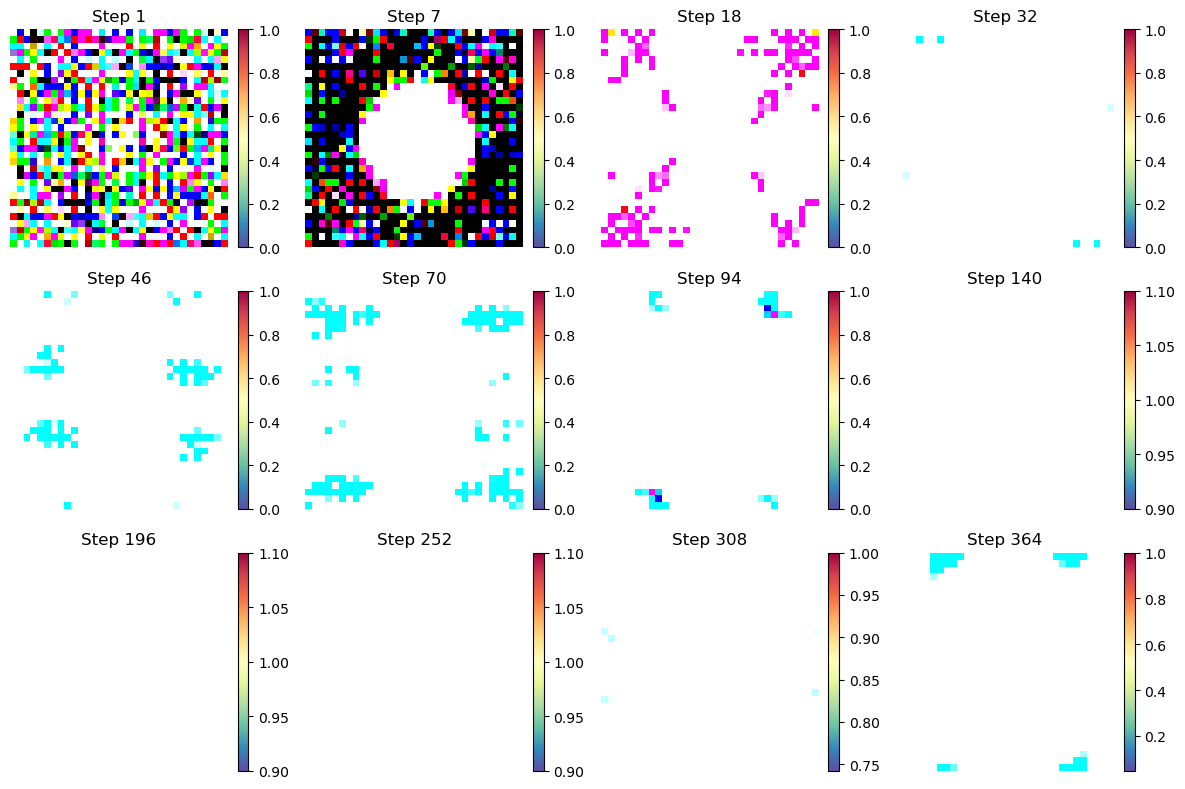

In [79]:
# Create a figure to visualize Fourier variance at different steps
plt.figure(figsize=(12, 8))
# Select 8 evenly spaced steps to visualize
num_steps_to_show = 12
step_indices = np.linspace(0, 75, num_steps_to_show, dtype=int)
# Create subplots in a 3x4 grid
for i, step_idx in enumerate(step_indices):
    plt.subplot(3, 4, i+1)
    # Get the Fourier variance for this step
    fourier_var = fourier_variance_col[step_idx]
    h_out = variance_map_to_filter(fourier_var, shifted=False).cpu()
    # Plot with logarithmic scale for better visibility and consistent color limits
    plt.imshow(torch.log1p(h_out), cmap='Spectral_r', )#vmin=vmin, vmax=vmax)
    plt.axis("off")
    # Add title with step information
    plt.title(f'Step {step_slice[step_idx]}')
    # Add colorbar to each subplot
    plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
# plt.suptitle('Fourier Variance Evolution (Log Scale)', y=1.05)
plt.show()


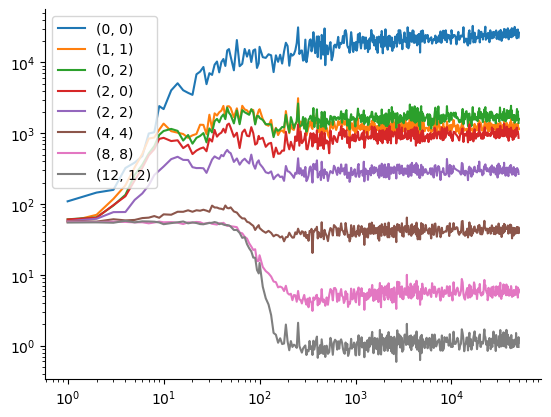

In [60]:
for entry in [(0,0), (1,1), (0, 2), (2, 0), (2,2), (4, 4), (8, 8), (12, 12)]:
    plt.plot(step_slice, fourier_variance_col[:, entry[0], entry[1], :].mean(dim=-1).cpu().numpy(), label=f"({entry[0]}, {entry[1]})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Scratch

In [56]:
diag_cov_x_sample_true_eigenbasis_traj.shape

torch.Size([719, 3072])

In [57]:
emer_time_df = compute_crossing_points(diag_cov_x_sample_true_eigenbasis_traj[-1,:].cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), 
                                       smooth_sigma=1, threshold_type="geometric_mean")

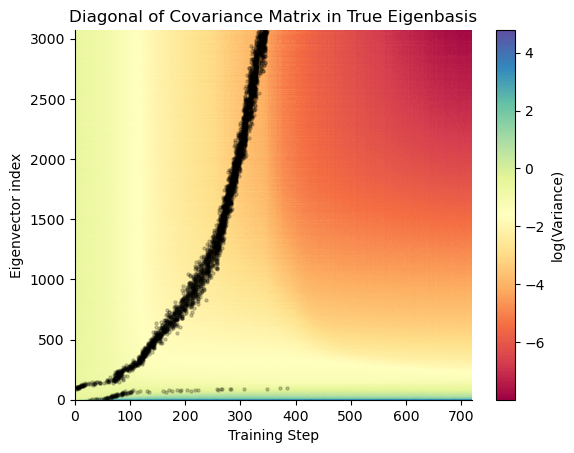

In [58]:
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral")
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"], emer_time_df.index, marker="o", c="k", s=5, alpha=0.2)
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.show()

In [22]:
compute_cov_alignment(img_cov.cuda(), img_eigvec.cuda())

tensor(1., device='cuda:0')

In [ ]:
vt_c = torch.matmul(img_eigvec.cuda().transpose(-2, -1), img_cov.cuda())
cov_rot = torch.matmul(vt_c, img_eigvec.cuda())

In [12]:
cov_rot

tensor([[ 1.7339e+02,  5.9638e-06, -4.4317e-06,  ..., -1.9718e-07,
          2.3988e-07, -9.5408e-07],
        [-4.9080e-06,  6.0114e+01, -1.0924e-05,  ..., -1.4437e-07,
         -1.4921e-06, -1.1772e-06],
        [-8.0515e-06, -9.7304e-06,  5.8021e+01,  ...,  4.7554e-07,
         -3.1593e-08,  3.7685e-07],
        ...,
        [ 3.2147e-08,  1.2681e-09,  1.0604e-07,  ...,  2.7279e-05,
          3.6979e-08, -1.9951e-09],
        [-1.4912e-08, -1.3684e-07, -2.8778e-08,  ...,  3.6612e-08,
          2.7954e-05,  3.7021e-08],
        [-2.4391e-07, -1.4261e-07,  1.4490e-08,  ..., -8.5750e-10,
          3.7493e-08,  2.7491e-05]], device='cuda:0')